In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from help_functions.evaluate_energymodels import evaluate_different_energymodels, evaluate_energymodel
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
from energy_consumption.feature_selection.extract.extract_energy_data import get_data

from energy_consumption.models.lasso.lasso import get_Lasso_forecasts
from energy_consumption.models.quantreg.quantreg_cali_short import get_QuantReg_forecasts
from energy_consumption.models.quantreg.quantreg_fs_ex import get_QuantRegFS_forecasts
from energy_consumption.models.quantreg.quantreg_ex_short import get_QuantRegExShort_forecasts
from energy_consumption.models.baseline import get_baseline_forecasts
from energy_consumption.models.knn.knn_cali import get_KNNRegression_forecasts
from energy_consumption.models.XGBoost.XGBoost import get_XGBoost_forecasts


In [2]:
energydata = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)

In [3]:
energydata = get_data(num_years=6.18, wednesday_morning=True)

100%|██████████| 321/321 [03:23<00:00,  1.58it/s]


In [ ]:
energydata

In [ ]:
lasso = {
    'name': 'lasso regression',
    'function': get_baseline_forecasts
}
evaluate_energymodel(
    lasso, energydata, last_x=24, weeks = True)

In [ ]:
# Functions work
lasso = {
    'name': 'lasso regression',
    'function': get_Lasso_forecasts
}

quantregcali = {
    'name': 'n = 1000, additional noise',
    'function': get_QuantReg_forecasts
}

quantregshortex = {
    'name': "QuantReg n = 1000, only exog. variables",
    'function': get_QuantRegExShort_forecasts
}

quantregfs = {
    'name': "n = 54027, only exog. variables",
    'function': get_QuantRegFS_forecasts
}

baseline = { 
    'name': 'baseline', 
    'function': get_baseline_forecasts
}

knn = {
    'name': 'knn',
    'function': get_KNNRegression_forecasts
}
xgboost = {
    'name': 'xgboost', 
    'function': get_XGBoost_forecasts
}

models = [quantregfs, quantregcali,quantregshortex]
evaluation = evaluate_different_energymodels(
    models, energydata, last_x=20, years=False, months=False, weeks=True)

### Visualize Comparison 

1. Create a table that only contains the different scores of the different models

In [11]:
models[0]['evaluation']

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,energy_consumption,score
date_time,,,,,,,,,,
2024-01-13 12:00:00,2024-01-25,energy,36 hour,51.004573,60.265428,63.476369,65.673812,69.781704,63.37225,3.747167
2024-01-13 16:00:00,2024-01-25,energy,40 hour,47.780517,57.214207,60.433407,63.052036,67.370534,62.16900,5.634008
2024-01-13 20:00:00,2024-01-25,energy,44 hour,43.995590,54.258470,57.907507,60.572469,64.317634,58.50575,4.771345
2024-01-14 12:00:00,2024-01-25,energy,60 hour,46.612414,56.266100,60.196502,63.213629,67.182599,58.77875,5.920026
2024-01-14 16:00:00,2024-01-25,energy,64 hour,43.388357,53.214880,57.153540,60.591853,64.771429,56.89600,5.015181
...,...,...,...,...,...,...,...,...,...,...
2023-09-16 16:00:00,2024-01-25,energy,40 hour,47.351412,52.099631,54.652464,57.040488,61.839431,46.16175,25.940630
2023-09-16 20:00:00,2024-01-25,energy,44 hour,43.527766,49.180927,52.191649,54.566926,58.707948,47.37125,11.891763
2023-09-17 12:00:00,2024-01-25,energy,60 hour,46.300819,51.129210,54.499747,57.316693,61.681228,46.18150,22.315067


In [12]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1, keys=names)

In [13]:
models[3]['evaluation'][models[3]['evaluation']['horizon'] == '40 hour']

IndexError: list index out of range

In [14]:
score_summary = pd.DataFrame()
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']


mean_score ={} # model, horizon, mean_score
for h in horizons: 
    mean_scores = []
    for m in models: 
        m_score = np.mean(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        mean_scores.append(m_score)
    score_summary[h] = mean_scores

score_summary

,36 hour,40 hour,44 hour,60 hour,64 hour,68 hour
0,15.866599,15.286314,10.513341,14.239080,14.017167,7.195886
1,7.834475,8.133836,7.112446,8.888398,8.780711,9.756990
2,5.820649,5.179071,3.848625,7.769889,7.473889,5.597233


In [15]:
score_summary = pd.DataFrame()
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

var_score = {}  # model, horizon, mean_score
for h in horizons:
    var_scores = []
    for m in models:
        m_score = np.var(m['evaluation']['score']
                          [m['evaluation']['horizon'] == h])
        var_scores.append(m_score)
    score_summary[h] = var_scores

score_summary

,36 hour,40 hour,44 hour,60 hour,64 hour,68 hour
0,51.644970,73.651291,17.676322,55.596205,82.528018,10.943733
1,9.227363,20.318261,9.632877,4.981880,14.443300,25.557463
2,29.032387,5.924567,1.743535,11.061221,11.855514,3.502915


In [16]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
mean_scores = []
var_scores = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score']
                      [m['evaluation']['horizon'] == h])
        names.append(col_name)

2.  Plot the densities of the obtained scores

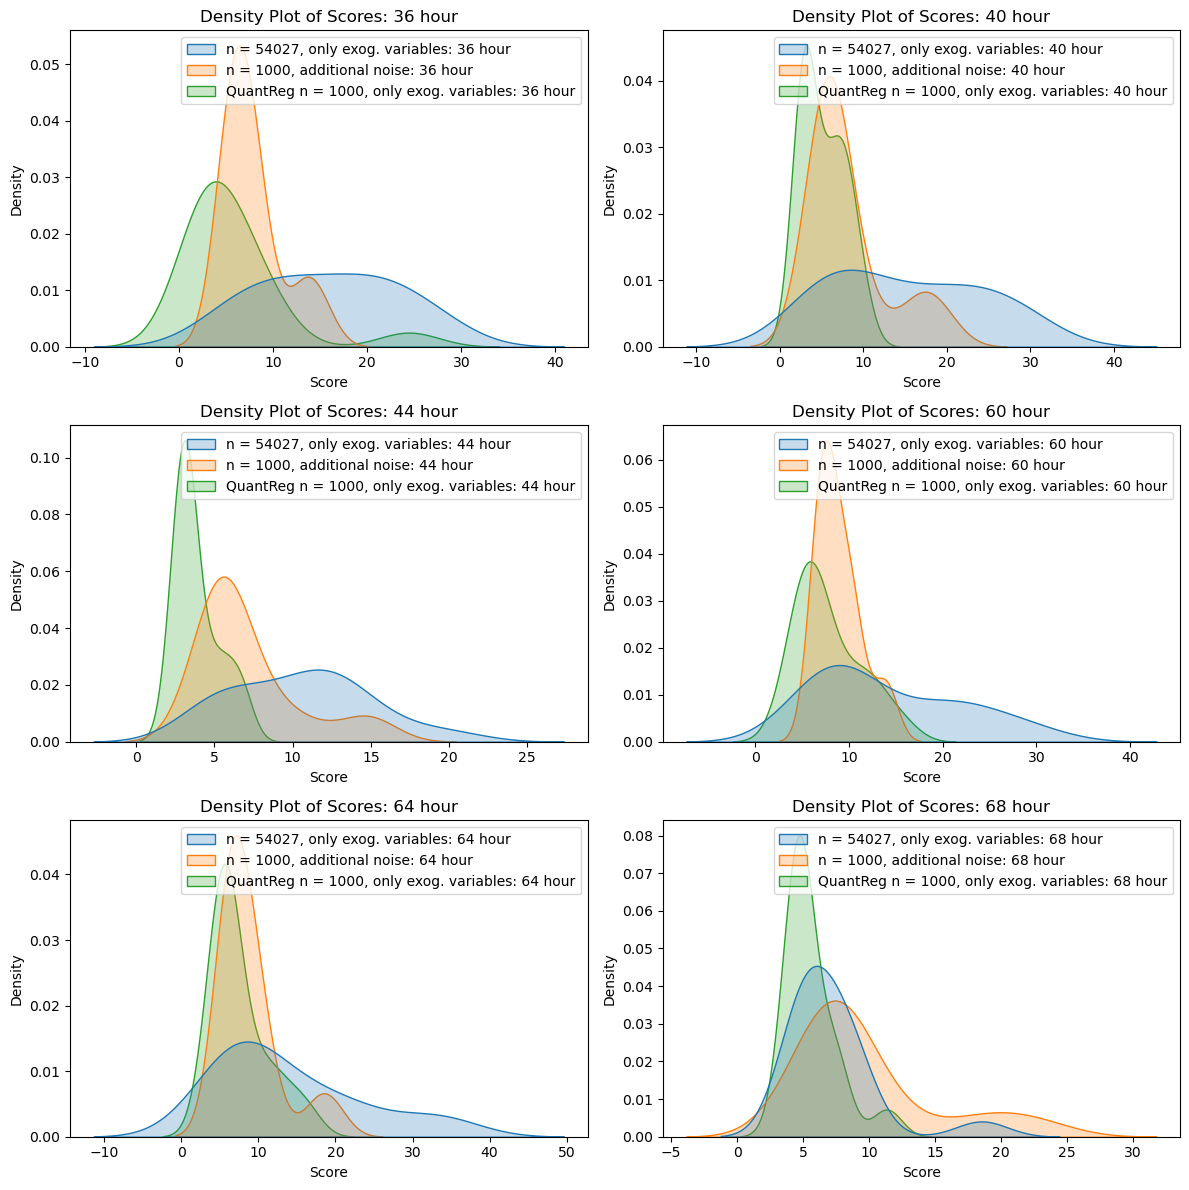

In [17]:
# Create subplots
fig, axes = plt.subplots(3,2, figsize=(12,12))

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Loop through each horizon
for i, h in enumerate(horizons):
    # Select columns related to the current horizon
    relevant_cols = [f'{m["name"]}: {h}' for m in models]

    # Filter the relevant data for the current horizon
    data_subset = score_df.loc[:, relevant_cols]

    # Create a KDE plot for the current horizon
    sns.kdeplot(data=data_subset, fill=True, ax=axes[i])

    # Set labels and title for each subplot
    axes[i].set_xlabel('Score')
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'Density Plot of Scores: {h}')

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

# Display the plots
plt.show()

Interpretation: Für Freitag ist timely besser, für Samstag nicht

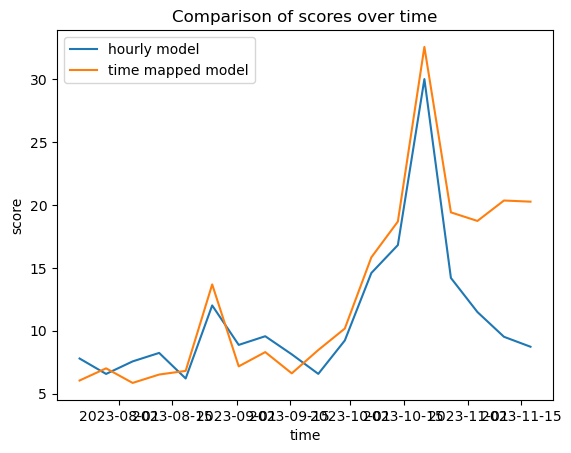

In [14]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['seasonal model hourly: 36 hour'].notna(
)]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model hourly: 36 hour'], label='hourly model')

plt.plot(score_df_36_no_na.index,
         score_df_36_no_na['seasonal model with time mapping: 36 hour'], label='time mapped model')

# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()